**[Object of Agentic Object Detection]**

1. Agentic: 

**[Pipeline Implementation]**

1. VLM Tool
2. Agentic object detection pipeline
3. Running the object detector
4. Why Numbered Batching for Inferencing
5. Critiquing and Refining the Query
6. Validation Bounding Box predictions utilizing the VLM

### 1. VLM Tool



* Input
    * Image(path/ base64)
    * User request
* Output
    * Object: [str]

In [56]:
import base64
import json
import base64, os, hashlib
import torch

from openai import OpenAI
from io import BytesIO
from PIL import Image
from dotenv import load_dotenv

In [57]:
# util function
# 프로젝트 루트 탐색
def find_project_root(marker_filename=".project-root"):
    current_dir = os.path.abspath(os.getcwd())
    while True:
        if os.path.isfile(os.path.join(current_dir, marker_filename)):
            return current_dir
        parent_dir = os.path.dirname(current_dir)
        if parent_dir == current_dir:
            raise FileNotFoundError(f"Could not find {marker_filename} in any parent directory.")
        current_dir = parent_dir

In [58]:
def encode_image(image_path):
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
    except Exception as e:
        print(f"Error encoding image: {e}")
        return None

In [99]:
class VLMTool:
    def __init__(self, api_key):
        self.client = OpenAI(api_key=api_key)

    def chat_completion(
        self,
        messages,
        model="o1",
        max_tokens=300,
        temperature=0.1,
        response_format=None
    ):
        """Calls GPT for chat completion.
        return first message of GPTs"""
        try:
            if model in ["gpt-4o", "gpt-4o-mini"]:
                response = self.client.chat.completions.create(
                    model=model,
                    messages=messages,
                    max_tokens=max_tokens,
                    temperature=temperature,
                    response_format=response_format if response_format else {"type": "text"}
                )
            elif model in ["o1"]:
                response = self.client.chat.completions.create(
                    model=model,
                    messages=messages,
                    response_format=response_format if response_format else {"type": "text"}
                )
            else:
                raise NotImplementedError("This model is not supported")

            return response.choices[0].message.content

        except Exception as e:
            print(f"Error calling LLM: {e}")
            return None

    def extract_objects_from_request(self, image_path, user_text, model="gpt-4o"):
        """ Asks the LLM to parse user request for which objects to detect/segment.
        Returns a list of objects in plain text."""
        base64_image = encode_image(image_path) # image encoding 방식 변경 가능
        if not base64_image:
            return None

        prompt = (
            "You are an AI assistant that identifies the primary subject for an object detection task from a user's request. "
            "Your goal is to extract ONLY the main object(s) the user wants to find, including their specific attributes like color or state. "
            "Pay close attention to the grammar. If an object is mentioned as part of a location or relationship (e.g., 'the cat on the chair', 'tomatoes hidden by leaves'), do NOT extract the contextual object (like 'chair' or 'leaves'). Extract only the primary subject of the request."
            "If the user asks for 'all objects', list what you see."
            "Respond ONLY with a comma-separated list of the primary objects and NOTHING ELSE."
            "For example, for 'Find the red tomatoes hidden by leaves', you should respond with 'red tomatoes'."
            "For 'Show me the dog on the bed', you should respond with 'dog'."
        )

        messages = [
            {"role": "system", "content": prompt},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": user_text},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                            "detail": "high"
                        }
                    }
                ]
            }
        ]

        result = self.chat_completion(messages, model=model)
        if result:
            detected_objects = [
                obj.strip().lower()
                for obj in result.split(",")
                if obj.strip()
            ]
            return detected_objects

        return []

In [60]:
"""
# chat_completion() 출력 예시 
import os
from dotenv import load_dotenv

project_root = find_project_root()
dotenv_path = os.path.join(project_root, ".env")
load_dotenv(dotenv_path) # .env 파일의 환경 변수를 os.environ에 로드 / 환경변수 전부 로드

api_key = os.getenv("OPENAI_API_KEY")
client = VLMTool(api_key=api_key)
chat_messages = [
    {"role": "system", "content": "You are a creative poet."},
    {"role": "user", "content": "Write a short poem about a lonely star."}
]

response = client.chat_completion(
    messages=chat_messages,
    model="gpt-4o",
    max_tokens=150,
    temperature=0.8
)
print(response)
"""

'\n# chat_completion() 출력 예시 \nimport os\nfrom dotenv import load_dotenv\n\nproject_root = find_project_root()\ndotenv_path = os.path.join(project_root, ".env")\nload_dotenv(dotenv_path) # .env 파일의 환경 변수를 os.environ에 로드 / 환경변수 전부 로드\n\napi_key = os.getenv("OPENAI_API_KEY")\nclient = VLMTool(api_key=api_key)\nchat_messages = [\n    {"role": "system", "content": "You are a creative poet."},\n    {"role": "user", "content": "Write a short poem about a lonely star."}\n]\n\nresponse = client.chat_completion(\n    messages=chat_messages,\n    model="gpt-4o",\n    max_tokens=150,\n    temperature=0.8\n)\nprint(response)\n'

In [61]:
# extract_objects_from_request() 출력 예시
project_root = find_project_root()
dotenv_path = os.path.join(project_root, ".env")
load_dotenv(dotenv_path)

api_key = os.getenv("OPENAI_API_KEY")
client = VLMTool(api_key=api_key)


image_path = r"C:\Users\KIST\agentic-object-detection\data\image1.jpg"

# Test1: 모든 객체 탐지
user_request_1 = "Find all objects in this picture."
objects_1 = client.extract_objects_from_request(image_path, user_request_1)
print(f"요청: {user_request_1}")
print(f"결과: {objects_1}")
print()


Error encoding image: [Errno 2] No such file or directory: 'C:\\Users\\KIST\\agentic-object-detection\\data\\image1.jpg'
요청: Find all objects in this picture.
결과: None



### 2. Agentic object detection pipeline

* Input
    * Image
    * Object labels
* Output
    * detection: [{bbox, score, label}]

=> for initial, final verification 

In [62]:
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image
import json

"""
from config import MODEL_TYPES, CONFIDENCE_THRESHOLD, INV_MODEL_TYPES
from utils.image_utils import draw_arrows_and_numbers, encode_image, draw_bounding_boxes
"""

class ObjectDetectionTool:
    """ 2. Agentic object detection pipeline"""
    """
    Performs object detection using GroundingDINO or OWL-ViT,
    plus an optional 'critique' (refinement) step with a VLM
    to yield a refined set of objects to detect.
    """
    def __init__(self, model_id, device, vlm_tool, confidence_threshold=0.2, concept_detection_model="gpt-4o", initial_critique_model="o1", final_critique_model="gpt-4o"):
        self.model_id = model_id
        self.processor = AutoProcessor.from_pretrained(model_id)
        self.model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
        self.device = device
        self.vlm_tool = vlm_tool  # The LLMTool that can handle vision (GPT-4V) or similar
        self.confidence_threshold = confidence_threshold
        self.concept_detection_model = concept_detection_model
        self.initial_critique_model = initial_critique_model
        self.final_critique_model = final_critique_model
        
        # We store bounding boxes for potential usage later (e.g., for SAM).
        self.last_detection_bboxes = []
        self.last_filtered_objects = []
    


### 3. Running the Object Detector

* Input
    * Image
    * initial_detection
* Output
    * annotated_image

In [63]:
""" Configuration """
# Model configuration
MODEL_TYPES = {
    "owlvit": "google/owlvit-base-patch32",
    "grounding_dino": "IDEA-Research/grounding-dino-tiny",
}

INV_MODEL_TYPES = {v:k for k,v in MODEL_TYPES.items()}

DEFAULT_MODEL_TYPE = "grounding_dino"
MODEL_ID = MODEL_TYPES[DEFAULT_MODEL_TYPE]

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Visualization
COLOR_PALETTE = [
    "red", "blue", "green", "purple", "orange", 
    "cyan", "magenta", "yellow", "brown", "pink"
]

# Threshold
CONFIDENCE_THRESHOLD = 0.2

In [64]:
import cv2
import base64
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont

def draw_arrows_and_numbers(image_path, detected_objects):
    """
    Draws arrows and numbers on an image to label detected objects.
    """
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    font = cv2.FONT_HERSHEY_SIMPLEX
    used_positions = []

    # Pad the image with a white border
    top, bottom, left, right = 50, 50, 50, 50
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    height, width, _ = img.shape

    for i, (num, obj, box) in enumerate(detected_objects):
        x1, y1, x2, y2 = map(int, box)
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2  # Center of the bounding box

        # Adjust coordinates for padded image
        x1 += left
        y1 += top
        x2 += left
        y2 += top
        cx += left
        cy += top

        # Determine arrow direction towards the nearest border
        distances = {'top': cy, 'bottom': height - cy, 'left': cx, 'right': width - cx}
        direction = min(distances, key=distances.get)

        if direction == 'top':
            arrow_end = (cx, top)
            text_position = (cx - 10, top - 10)
        elif direction == 'bottom':
            arrow_end = (cx, height - bottom)
            text_position = (cx - 10, height - 5)
        elif direction == 'left':
            arrow_end = (left, cy)
            text_position = (left - 30, cy + 5)
        else:
            arrow_end = (width - right, cy)
            text_position = (width - 30, cy + 5)

        # Draw the dashed arrow from the object center to the border
        color = (0, 0, 0)  # Black color for all arrows
        line_type = cv2.LINE_4
        cv2.arrowedLine(img, (cx, cy), arrow_end, color, 2, tipLength=0.3)

        # Draw a semi-transparent rectangle behind the text
        overlay = img.copy()
        cv2.rectangle(overlay, (text_position[0] - 5, text_position[1] - 20), (text_position[0] + 30, text_position[1] + 5), (0, 0, 0), -1)
        alpha = 0.5
        cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

        # Draw the number at the border with black text
        cv2.putText(img, str(num), text_position, font, 0.5, color, 2)

    # Create dynamic output path based on input image path
    base_name = os.path.basename(image_path)
    name_part, ext_part = os.path.splitext(base_name)
    output_filename = f"labeled_objects_{name_part}{ext_part}"
    
    # Correctly construct the path relative to the notebook's location
    output_dir = os.path.join("..", "data", "output")
    os.makedirs(output_dir, exist_ok=True)
    labeled_image_path = os.path.join(output_dir, output_filename)
    
    cv2.imwrite(labeled_image_path, img)
    return labeled_image_path

In [65]:
def _run_detector(self, image_path, query_list):
    """
    Low-level routine to run the detection model on `query_list`.
    Returns: (detected_objects_final, labeled_image_path)
    Where `detected_objects_final` = [(num, label, [x1,y1,x2,y2]), ...].
    """
    from PIL import ImageFont
    
    # Format queries for the model
    if INV_MODEL_TYPES[self.model_id] == "owlvit":
        formatted_queries = [f"An image of {q}" for q in query_list]
    elif INV_MODEL_TYPES[self.model_id] == "grounding_dino":
        formatted_queries = " ".join([f"{q}." for q in list(set(query_list))])
    else:
        raise NotImplementedError("Model not supported")

    # Load image
    img = Image.open(image_path).convert("RGB")
    inputs = self.processor(
        text=formatted_queries, 
        images=img, 
        return_tensors="pt", 
        padding=True, 
        truncation=True
    ).to(self.device)

    # PyTorch gradient 계산 비활성화
    self.model.eval()
    with torch.no_grad():
        outputs = self.model(**inputs)
    
    # Post-process bounding boxes
    if INV_MODEL_TYPES[self.model_id] == "grounding_dino":
        results = self.processor.post_process_grounded_object_detection(
            outputs, 
            inputs.input_ids,
            target_sizes=[img.size[::-1]]
        )
        boxes = results[0]["boxes"]
        scores = results[0]["scores"]
        labels = results[0]["text_labels"]
    elif INV_MODEL_TYPES[self.model_id] == "owlvit":
        logits = torch.max(outputs["logits"][0], dim=-1)
        scores = torch.sigmoid(logits.values).cpu().numpy()
        labels = logits.indices.cpu().numpy()
        boxes = outputs["pred_boxes"][0].cpu().numpy()
    else:
        raise NotImplementedError("Model not supported")            

    detected_objects_final = []
    idx = 1
    for score, box, label in zip(scores, boxes, labels):
        if score < self.confidence_threshold:
            continue
        detected_objects_final.append((idx, label, box.tolist()))
        idx += 1

    # Draw numbers
    labeled_image_path = draw_arrows_and_numbers(image_path, detected_objects_final)
    return detected_objects_final, labeled_image_path

# 클래스에 메서드 추가
ObjectDetectionTool._run_detector = _run_detector

#### Exercise: detection + visualization 

In [66]:
# 환경 설정
project_root = find_project_root()
dotenv_path = os.path.join(project_root, ".env")
load_dotenv(dotenv_path)
api_key = os.getenv("OPENAI_API_KEY")

# VLMTool 초기화
vlm_tool = VLMTool(api_key=api_key)

# ObjectDetectionTool 초기화
detector = ObjectDetectionTool(
    model_id=MODEL_ID,  # "IDEA-Research/grounding-dino-tiny"
    device=DEVICE,      # "cuda" or "cpu"
    vlm_tool=vlm_tool,
    confidence_threshold=CONFIDENCE_THRESHOLD,  # 0.2
    concept_detection_model="gpt-4o",
    initial_critique_model="o1",
    final_critique_model="gpt-4o"
)

print(f"  - Model: {MODEL_ID}")
print(f"  - Device: {DEVICE}")
print(f"  - Confidence threshold: {CONFIDENCE_THRESHOLD}")

  - Model: IDEA-Research/grounding-dino-tiny
  - Device: cuda
  - Confidence threshold: 0.2


In [67]:
# === Object Detection ===
image_path = r"C:\Users\KIST\agentic-object-detection\data\input\image1.jpg"

# 사용자 요청에서 객체 추출 (VLM 사용)
user_request = "Detect all objects in this image"
objects_to_detect = vlm_tool.extract_objects_from_request(image_path, user_request)
print(f" List of Object: {objects_to_detect}")
print()

# detection
detected_objects, labeled_image_path = detector._run_detector(image_path, objects_to_detect)
print(f"🎯 Number of detected object: {len(detected_objects)}")
print(f"📁 Labeled image: {labeled_image_path}")
print()

# reult
print("Final detections:")
for num, label, bbox in detected_objects:
    x1, y1, x2, y2 = bbox
    print(f"  [{num}] label: {label}, box: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")

 List of Object: ['tomatoes', 'leaves', 'stems', 'soil', 'pathway', 'support structures.']

🎯 Number of detected object: 16
📁 Labeled image: ..\data\output\labeled_objects_image1.jpg

Final detections:
  [1] label: tomatoes, box: (103.5, 215.2, 157.1, 270.2)
  [2] label: tomatoes, box: (55.0, 244.3, 111.2, 295.3)
  [3] label: tomatoes, box: (153.8, 82.7, 196.8, 124.2)
  [4] label: tomatoes, box: (111.6, 73.9, 165.4, 116.5)
  [5] label: tomatoes, box: (185.2, 195.0, 220.2, 222.0)
  [6] label: tomatoes, box: (143.7, 182.1, 186.2, 221.1)
  [7] label: pathway, box: (257.5, 112.8, 437.8, 340.0)
  [8] label: tomatoes, box: (93.0, 323.4, 120.0, 340.5)
  [9] label: tomatoes, box: (78.7, 7.6, 112.0, 39.1)
  [10] label: tomatoes, box: (52.2, 3.1, 81.1, 31.2)
  [11] label: leaves, box: (0.8, 1.1, 275.3, 339.7)
  [12] label: leaves, box: (41.7, 143.8, 98.5, 222.7)
  [13] label: support structures, box: (276.1, 1.3, 327.6, 76.9)
  [14] label: leaves, box: (171.2, 291.4, 221.2, 340.2)
  [15] label: 

Original image:


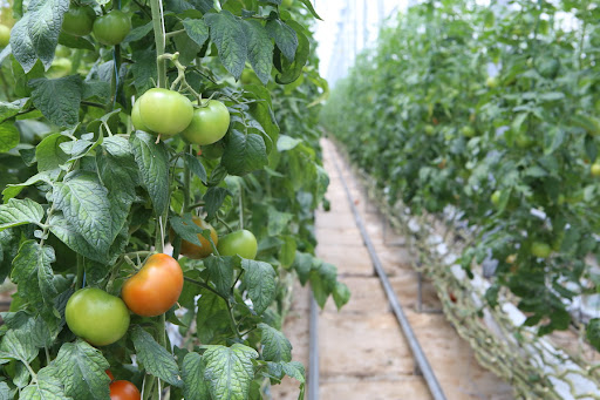


Annotated image:


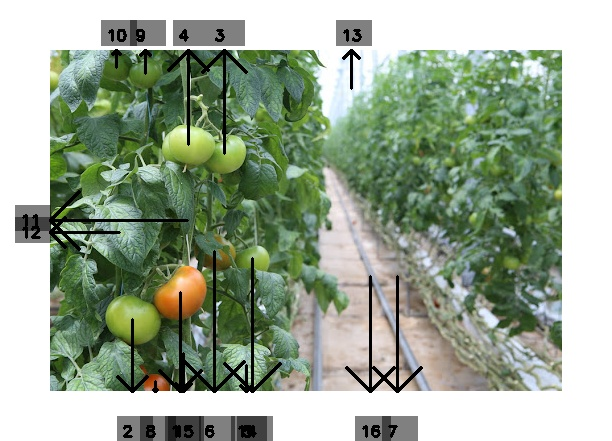

In [68]:
# === 결과 이미지 표시 ===

from PIL import Image
from IPython.display import display

# 원본 이미지
print("Original image:")
original_img = Image.open(image_path)
display(original_img.resize((600, 400)))

# 탐지 결과 이미지
print("\nAnnotated image:")
labeled_img = Image.open(labeled_image_path)
display(labeled_img)

📋 Extract specific object: ['green tomatoes']
🎯 Nummber of objects: 13
📁 Labeled image: ..\data\output\labeled_objects_image1.jpg

🎯 Number of detected object: 16


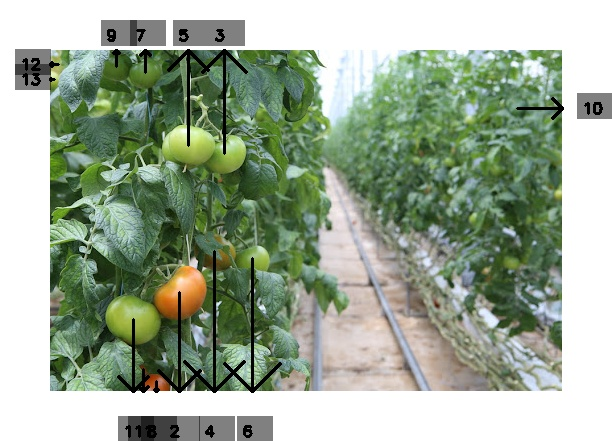

Final detections:
  [1] label: green tomatoes, box: (55.1, 244.4, 111.2, 295.3)
  [2] label: green tomatoes, box: (103.4, 215.4, 157.0, 270.2)
  [3] label: green tomatoes, box: (153.4, 83.0, 196.6, 124.1)
  [4] label: green tomatoes, box: (143.6, 182.7, 186.2, 221.1)
  [5] label: green tomatoes, box: (112.1, 74.2, 165.3, 116.2)
  [6] label: green tomatoes, box: (185.2, 195.3, 220.0, 222.0)
  [7] label: green tomatoes, box: (78.8, 7.4, 112.0, 39.0)
  [8] label: green tomatoes, box: (93.4, 323.6, 119.8, 340.7)
  [9] label: green tomatoes, box: (52.0, 2.2, 81.4, 31.0)
  [10] label: green tomatoes, box: (458.8, 49.2, 477.3, 67.2)
  [11] label: green tomatoes, box: (89.5, 314.0, 97.0, 325.9)
  [12] label: tomatoes, box: (0.2, 5.8, 17.0, 24.6)
  [13] label: green tomatoes, box: (0.0, 20.6, 9.1, 39.8)


In [77]:
# === 특정 객체만 탐지 ===

user_request_specific = "Detect green colored tomatoes in this picture."
specific_objects = vlm_tool.extract_objects_from_request(image_path, user_request_specific)
print(f"📋 Extract specific object: {specific_objects}")

detected_specific, labeled_specific_path = detector._run_detector(image_path, specific_objects)
print(f"🎯 Nummber of objects: {len(detected_specific)}")
print(f"📁 Labeled image: {labeled_specific_path}")
print()

print(f"🎯 Number of detected object: {len(detected_objects)}")
# 결과 표시
labeled_specific_img = Image.open(labeled_specific_path)
display(labeled_specific_img)

# 상세 결과 출력
print("Final detections:")
for num, label, bbox in detected_specific:
    x1, y1, x2, y2 = bbox
    print(f"  [{num}] label: {label}, box: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")

### 4. Why Numbered Batching for Inferencing

* 목적: 이후 과정에서 VLM 호출 최적화

* Brute-force crop loop vs Numbered batching 
    * Brute-force crop loop
    
    * Numbered batching

### 5. Critiquing and Refining the Query

* 목적: initial detection의 결과가 미미할 때 '선택적'으로 '추가 연산'
* User request가 세분화된 라벨이라면 bbox가 threshold를 넘을 수 없으므로 해당 문제를 해결하기 위한 방식

* Input
    * annotated image(conclude arrow & numbered label) 
    * User request
    * initial detection

* Process
    * 실패한 케이스에 대하여 라벨이 구체적인지를 질문
    * 하의어를 포함하는 상의어로 변경 ex. 나뭇잎에 가려진 토마토 -> 토마토

* Output
    * refined concept
    - {"reasoning": "...", "refined_list": "dog, shoe, flower"} 같은 JSON


In [70]:
def _critique_and_refine_query(self, user_request, original_concepts, labeled_image_path, objects_detected, model="o1"):
        """
        Asks the VLM/LLM: "We tried to detect <objects_detected> for the user request, 
        but maybe we need a refined set of objects. 
        Return a new list of objects or concepts to detect."
        """
        base64_labeled_image = encode_image(labeled_image_path)

        # For clarity, let's pass the original user request and 
        # the currently detected object list to the LLM. 
        # The LLM can propose a refined set of objects to detect.
        refine_messages = [
    {
    "role": "system",
    "content": """
        You are an AI system that refines detection queries. 
        You are provided with the outputs from an object detection model, along with the user's request and the objects from the user's request that were extracted and provided to the object detection model.
        Your task is to analyze whether the object detector has extracted the results properly to the user's request and, if not, refine the queries by generalizing concepts where possible.
        
        Important guidelines:
        1. If the detection results are already good, no need to refine. 
           - In that case, provide reasoning indicating no refinement was necessary and return the same list.
        2. If the detection results are poor or null, propose synonyms or more generic categories and explain why. Wherever possible, retain the singular version of the concept.
        3. Return your final answer as a JSON object with exactly two fields: "reasoning" and "refined_list".
           - "reasoning" is a short explanation of why you refined or didn't refine.
           - "refined_list" is a comma-separated list of object names that should be re-tried in detection.
        4. Output ONLY the JSON, and no other text.

        Below are some examples:

        EXAMPLE 1
        User's Request: Detect the teacup poodle
        Original concept: "Teacup poodle"

        Final output:
        {
          "reasoning": "The provided image does not have any detections for the concept of teacup poodle. The concept "teacup poodle" might be a very specific concept for the model to detect. This could  be refined to a more higher-level and generic concept like 'Dog',
          "refined_list": "dog"
        }

        EXAMPLE 2
        User's Request: Detect the sparkly stiletto shoe
        Original concept: "Sparkly stiletto shoe"

        Final output:
        {
          "reasoning": "The provided image does not specific detections that correspond for 'Sparkly stiletto shoe'. 'Sparkly stiletto shoe' might be too specific for the model. Refining to 'shoe', a more generic concept might increase the likelihood of detection.",
          "refined_list": "shoe"
        }

        EXAMPLE 3
        User's Request: Detect the hydrangea
        Original concept: "Hydrangea"

        Final output:
        {
          "reasoning": "No detections found for 'hydrangea'. The model might struggle with specific flower types. Refining to the more general concept 'flower' could yield better results.",
          "refined_list": "flower"
        }

        EXAMPLE 4
        User's Request: Detect the gourmet cheeseburger
        Original concept: "Gourmet cheeseburger"

        Final output:
        {
          "reasoning": "No detections observed for 'Gourmet cheeseburger'. 'Gourmet cheeseburger' might be too specific. Refining to 'hamburger' as it aligns with the detected object.",
          "refined_list": "hamburger"
        }

        EXAMPLE 5
        User's Request: Detect the red sports car
        Original concept: "Red sports car"

        Final output:
        {
          "reasoning": "The provided image does not have any reliable detections for 'red sports car'. Color-based detection might be challenging. Refining to the more general concept 'car' could improve detection.",
          "refined_list": "car"
        }

        Remember: 
        • If no refinement is needed (the concept is recognized well), explain that in the reasoning and return the same concept. 
        • When refinement is necessary, prioritize more generic or abstract categories that may be more reliably detected by the model.
        • Provide only the JSON. 
        • No extra commentary.
        """
        },

        {"role": "user", "content": [
            {"type": "text", "text": f"User's request: {user_request}\n Original Concepts for Detection: {original_concepts}"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_labeled_image}", "detail": "high"}}
        ]}
        ]
        refine_response = self.vlm_tool.chat_completion(refine_messages, model=model, response_format={"type": "json_object"})
        
        refined_response_objects = json.loads(refine_response)["refined_list"].split(",")

        if not refined_response_objects:
            return []
        
        refined_list = [r.strip().lower() for r in refined_response_objects if r.strip()]
        return refined_list
ObjectDetectionTool._critique_and_refine_query = _critique_and_refine_query

#### Exercise

refined concept list: ['tomato']
refined list differs → running second pass...
second-pass detections: 11 | labeled: ..\data\output\labeled_objects_image1.jpg

Final detections:
  [1] label: tomato | box: (103.5, 215.5, 157.0, 270.2)
  [2] label: tomato | box: (55.2, 244.5, 111.2, 295.4)
  [3] label: tomato | box: (143.7, 183.1, 186.2, 221.1)
  [4] label: tomato | box: (185.2, 195.4, 220.0, 222.0)
  [5] label: tomato | box: (111.8, 74.3, 165.3, 116.4)
  [6] label: tomato | box: (78.8, 7.5, 112.1, 39.0)
  [7] label: tomato | box: (93.4, 323.7, 119.8, 340.9)
  [8] label: tomato | box: (52.1, 2.0, 81.6, 31.1)
  [9] label: tomato | box: (89.5, 314.1, 97.1, 326.4)
  [10] label: tomato | box: (153.2, 83.1, 196.5, 124.1)
  [11] label: tomato | box: (0.0, 20.5, 9.2, 39.7)


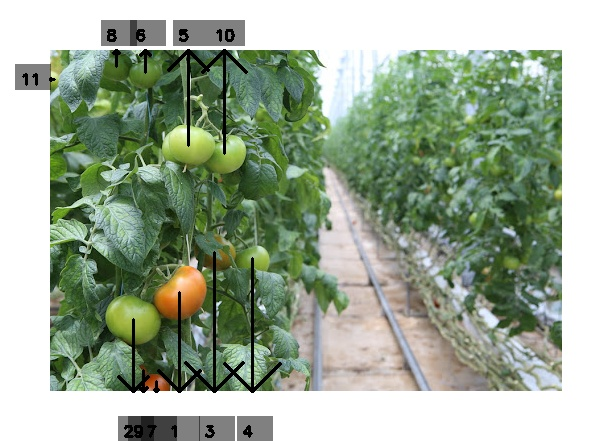

In [71]:
# critique & refine
refined_concept_list = detector._critique_and_refine_query(
    user_request = user_request_specific,
    original_concepts = specific_objects,
    
    labeled_image_path = labeled_image_path,
    objects_detected = detected_specific,
    model="o1"   
)
print("refined concept list:", refined_concept_list)

# second detection - selectively
def _normalized_list(xs):
    return sorted([x.strip().lower() for x in xs if x and x.strip()])

if _normalized_list(refined_concept_list) != _normalized_list(specific_objects) and len(refined_concept_list) > 0:
    print("refined list differs → running second pass...")
    detected_refined, labeled_refined_path = detector._run_detector(image_path, refined_concept_list)
    print(f"second-pass detections: {len(detected_refined)} | labeled: {labeled_refined_path}")

    # 최종 사용 결과 선택 (2차가 유의미하면 교체)
    final_detections = detected_refined
    final_labeled = labeled_refined_path
else:
    print("refinement not needed or identical → keep first pass.")
    final_detections = detected_specific
    final_labeled = labeled_image_path

# 상세 결과 출력
print("\nFinal detections:")
for num, label, bbox in final_detections:
    x1, y1, x2, y2 = bbox
    print(f"  [{num}] label: {label} | box: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")

try:
    display(Image.open(final_labeled))
except:
    pass

### 6. Validation Bounding Box predictions utilizing the VLM

annotated image → VLM: 일괄 batching → 유효한 bbox filtering

In [ ]:
def _validate_bboxes_with_llm(self, user_request, labeled_image_path, model="o1"):
        """
        Pass the labeled image to the LLM to filter bounding boxes 
        based on user request. Returns 'valid_numbers' list.
        """
        base64_labeled_image = encode_image(labeled_image_path) # VLM API에 이미지 직접 전송을 위함 
        
        messages = [
            {"role": "system", "content": "You are an AI reviewing an object detection output.\n"
                                          "All detected objects have been marked with an arrow mapping to a corresponding number.\n"
                                          "The image contains arrows labeled with numbers pointing to specific objects.\n"
                                          "Your task is to identify the objects indicated by these arrows and determine whether each detected object is relevant to the user's query.\n"
                                          "For each numbered arrow:\n"
                                          "1. Identify the object being pointed to.\n"
                                          "2. Provide a brief description of the object (e.g., 'top-left cup with blue leaves', 'bottom-right cup with watermelon pattern', or 'background birdcage').\n"
                                          "3. Analyze whether the object is valid based on the context and the user's instructions.\n"
                                          "4. Provide a clear, step-by-step explanation for each object's validity decision.\n"                                          
                                          "Return a JSON object with the reasoning and list of valid numbers matching the user's request.\n"
                                          "Example output:\n"
                                          "{ \"reasoning\": <reasoning> , \"valid_numbers\": {object_num :\"object_name\"} }"
            },
            {"role": "user", "content": [
                {"type": "text", "text": f"The user's original request was: {user_request}"},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_labeled_image}", "detail": "high"}}
            ]
            }
        ] # 각 번호가 가리키는 객체가 사용차의 요청과 관련 있는지 판단 

        valid_numbers_json = self.vlm_tool.chat_completion(
            messages, 
            model=model,
            response_format={"type": "json_object"}
        ) # VLM api 전송, 

        try:
            valid_numbers_data = json.loads(valid_numbers_json)
            return valid_numbers_data.get("valid_numbers", {})
        except json.JSONDecodeError:
            return []
        # VLM으로부터 받은 JSON 형식의 문자열 응답 > 파이썬 딕셔너리 
ObjectDetectionTool._validate_bboxes_with_llm = _validate_bboxes_with_llm

pipeline 재정리 

1. label 변화 O
    * Concept detector →  Objection detector + Visualization → Refined detection → Final filtering + visualization    
2. label 변화 x
    * Concept detector → Final filtering + visualization    

In [ ]:
def draw_rounded_rectangle(draw, box, radius, outline, width):
    """
    Draws a rounded rectangle on an image.

    This function creates a rectangle with rounded corners by drawing straight lines 
    and pieslices for the corners.

    Args:
        draw (ImageDraw.Draw): The ImageDraw object used to draw on the image.
        box (tuple): Coordinates of the rectangle as (x1, y1, x2, y2).
        radius (int): The radius of the rounded corners.
        outline (str or tuple): The color of the rectangle outline.
        width (int): The width of the rectangle outline.

    Notes:
        - The corners are drawn as quarter circles using the `pieslice` method.
        - The rectangle is drawn by connecting these corners with lines.
    """
    x1, y1, x2, y2 = box
    draw.rectangle([x1 + radius, y1, x2 - radius, y2], outline=outline, width=width)

In [94]:
def draw_bounding_boxes(image_path, filtered_objects):
    """
    Draws bounding boxes with labels on an image.

    For each object in the `filtered_objects` list, this function draws a bounding box 
    with rounded corners and labels it with the corresponding object name.

    Args:
        image_path (str): Path to the input image file.
        filtered_objects (list of tuples): Each tuple contains (number, label, box) where:
            - number (int): Identifier or index for the object.
            - label (str): Label for the detected object.
            - box (tuple): Bounding box coordinates as (x1, y1, x2, y2).

    Returns:
        Image.Image: The image with bounding boxes and labels drawn.

    Notes:
        - Bounding boxes have rounded corners.
        - Labels are displayed in a semi-transparent box above each bounding box.
        - The font is assumed to be `arial.ttf` and should exist in the working directory.
    """
    # Open the image
    final_img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(final_img)
    font = ImageFont.truetype("arial.ttf", 20)

    for num, lbl, box in filtered_objects:
        x1, y1, x2, y2 = box
        box_width = x2 - x1
        box_height = y2 - y1

        # Define styles
        outline_color = "red"
        outline_width = 3
        radius = 10  # Radius for rounded corners
        label_fill_color = (255, 0, 0, 128)  # Semi-transparent red
        text_color = "white"
        padding = 5

        # Draw rounded rectangle for bounding box
        draw.rounded_rectangle([x1, y1, x2, y2], radius=radius, outline=outline_color, width=outline_width)

        # Calculate text size
        left, top, right, bottom = draw.textbbox((0, 0), lbl, font=font)
        text_width = right - left
        text_height = bottom - top

        # Position for label box
        label_box = [x1, y1 - text_height - 2 * padding, x1 + text_width + 2 * padding, y1]

        # Draw label box
        draw.rectangle(label_box, fill=label_fill_color)

        # Draw text
        text_position = (x1 + padding, y1 - text_height - padding)
        draw.text(text_position, lbl, fill=text_color, font=font)

    return final_img

In [95]:
def run(self, image_path, user_request, do_critique=True):
        """
        Full pipeline:
        1. Extract objects from user request (LLM).
        2. Detect bounding boxes with that query.
        3. LLM-based validation step => filter bounding boxes.
        4. (Optional) Critique Step => refine the query if needed.
        5. Re-run detection with refined queries.
        6. Final LLM validation => final bounding boxes and annotation.
        """
        # do_critique: critique 여부 선택 

        # ---------------------------------------------------
        # Step 1: initial user queries from request
        # ---------------------------------------------------
        objects_to_detect = self.vlm_tool.extract_objects_from_request(image_path, user_request, model=self.concept_detection_model)
        if not objects_to_detect:
            return None, "⚠️ No objects to detect or invalid request."

        # ---------------------------------------------------
        # Step 2: run detection with the initial user queries
        # ---------------------------------------------------
        detected_objects_final, labeled_image_path = self._run_detector(image_path, objects_to_detect)
        
        # ------------------------------------------------------
        # Step 3: Initial Critique and Object Concept Refinement
        # ------------------------------------------------------
        if do_critique:
            current_labels = ",".join(set([str(lbl) for _, lbl, _ in detected_objects_final]))

            refined_query_list = self._critique_and_refine_query(
                user_request=user_request,
                original_concepts=current_labels,
                labeled_image_path=labeled_image_path,
                objects_detected=current_labels,
                model=self.initial_critique_model
            )
            
            # If the refined list is empty or identical, we might skip re-running
            # But let's suppose we only re-run if we actually get a new set.
            if refined_query_list and set(refined_query_list) != set(objects_to_detect):
                # Re-run detection with refined query
                detected_objects_final, labeled_image_path = self._run_detector(image_path, refined_query_list)
                if not detected_objects_final:
                    return None, "No objects found for the initial query."
        
        # ---------------------------------------------------
        # Step 4: LLM-based critique
        # ---------------------------------------------------
        valid_numbers = self._validate_bboxes_with_llm(user_request, labeled_image_path, model=self.final_critique_model)
        # dictionary 형태의 유효한 객체 번호 목록

        # filter bounding boxes
        if valid_numbers: 
            filtered_objects = [(n, valid_numbers[str(n)], box) for (n, lbl, box) in detected_objects_final if str(n) in valid_numbers]
            # detection에서 유효한 객체 번호 목록에 따른 detection 박스에 대한 튜플만 걸러내기 
        else:
            filtered_objects = detected_objects_final
        

        # store them
        self.last_detection_bboxes = [x[-1] for x in filtered_objects] # 튜플의 마지막 항목 - bbox 좌표 리스트
        self.last_filtered_objects = filtered_objects


        # ---------------------------------------------------
        # Step 5: Produce final annotated image
        # ---------------------------------------------------
        final_img = draw_bounding_boxes(image_path, filtered_objects)

        final_text = (
            f"🔍 Validated objects: {', '.join(set(str(lbl) for _, lbl, _ in filtered_objects))}"
        )
        return final_img, final_text

ObjectDetectionTool._run = run

#### Exercise

🖼️  Image: image1.jpg
🗣️  User Request: 'Find the red tomatoes hidden by leaves'
------------------------------

✅ FINAL RESULT ✅
🔍 Validated objects: red tomato, orange tomato


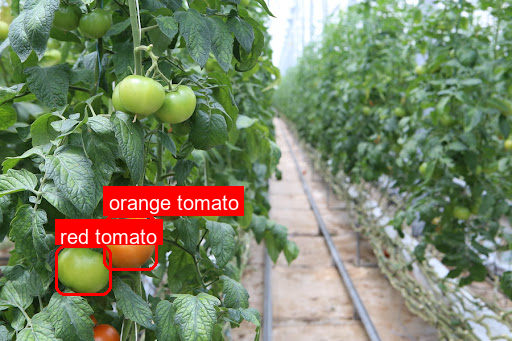

In [101]:
# === Full Agentic Detection Pipeline Example ===

# 1. Define the image path and the complex user request in English
image_path = r"C:\Users\KIST\agentic-object-detection\data\input\image1.jpg"
user_request = "Find the red tomatoes hidden by leaves"

print(f"🖼️  Image: {os.path.basename(image_path)}")
print(f"🗣️  User Request: '{user_request}'")
print("-" * 30)

# 2. Execute the full pipeline using the _run method
# We enable both critique and validation steps for the full agentic experience.
final_image, result_text = detector._run(
    image_path=image_path,
    user_request=user_request,
    do_critique=True
)

# 3. Display the final results
print("\n" + "=" * 30)
print("✅ FINAL RESULT ✅")
print("=" * 30)

if final_image:
    print(result_text)
    display(final_image)
else:
    # If the process returns no image, it means no valid objects were found.
    print(result_text)
    print("\nCould not find any objects matching the request after the full process.")
    # Display the original image for context
    print("Original Image:")
    display(Image.open(image_path))
